In [21]:
import tkinter as tk

In [22]:
%load_ext autoreload
%autoreload 2
!pip install scipy
!pip install matplotlib

import scipy
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import random
import sir_model
import json
from random import randint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You should consider upgrading via the '/Users/dmosaphir/SIFT/Projects/ASKEM/code/ts-trajectory/.venv/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/dmosaphir/SIFT/Projects/ASKEM/code/ts-trajectory/.venv/bin/python3 -m pip install --upgrade pip' command.


In [23]:
line_id = None
line_points = []
line_options = {}
line_points_saved = []
clicked_points_saved = []

def draw_line(event):
    global line_id
    line_points.extend((event.x, event.y))
    if line_id is not None:
        canvas.delete(line_id)
    line_id = canvas.create_line(line_points, **line_options)


def set_start(event):
    line_points.extend((event.x, event.y))


def end_line(event=None):
    global line_id
    line_points_saved.extend(line_points)
    line_points.clear()
    line_id = None
    
def draw_point(event):
    canvas.create_oval(event.x, event.y, event.x, event.y, width = 5, fill = 'black')
    clicked_points_saved.extend((event.x, event.y))


In [24]:
root = tk.Tk()

canvas = tk.Canvas()
canvas.pack()

#canvas.bind('<Button-1>', draw_point)
canvas.bind('<Button-1>', set_start)
canvas.bind('<B1-Motion>', draw_line)
canvas.bind('<ButtonRelease-1>', end_line)

root.mainloop()

In [25]:
t_vals = line_points_saved[::2]
y_vals = line_points_saved[1::2]
print(t_vals)
print(y_vals)
y_rescaled = y_vals/np.max(y_vals)
# print(y_rescaled)


[17, 19, 21, 23, 26, 30, 33, 37, 40, 43, 45, 47, 49, 52, 55, 58, 62, 65, 68, 70, 73, 76, 79, 81, 83, 84, 86, 87, 89, 91, 94, 96, 98, 100, 101, 102, 102, 103, 104, 104, 105, 106, 106, 107, 107, 107, 108, 109, 109, 110, 111, 111, 112, 113, 114, 115, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 129, 132, 135, 138, 141, 144, 146, 148, 150, 153, 155, 157, 160, 162, 165, 167, 169, 172, 173, 175, 177, 179, 181, 183, 185, 186, 188, 189, 191, 193, 194, 196, 197, 198, 200, 202, 204, 205, 207, 208, 210, 212, 214, 216, 218, 220, 222, 223, 224, 226, 227, 229, 230, 232, 234, 236, 237, 239, 241, 243, 244, 246, 247, 248, 249, 250, 251, 252]
[183, 183, 183, 183, 183, 184, 184, 184, 184, 185, 185, 185, 185, 185, 184, 184, 183, 183, 182, 180, 178, 176, 174, 172, 171, 169, 167, 165, 163, 162, 160, 159, 158, 157, 156, 155, 154, 152, 150, 148, 145, 142, 139, 136, 133, 130, 126, 123, 121, 119, 117, 115, 112, 110, 108, 106, 105, 104, 102, 101, 99, 98, 97, 95, 93, 91, 90, 88, 87, 85, 83, 81, 80, 79, 78, 7

In [26]:
# initialize recording of parameter choices and true/false


# USER: set bounds
beta_search_bounds = [0.1,0.25]
gamma_search_bounds = [0.01,0.04]

In [27]:
# USER: list how many points for each parameter you'd like to synthesize

beta_values_to_synthesize = 10
gamma_values_to_synthesize = 10

In [28]:
search_points_beta = np.linspace(beta_search_bounds[0], beta_search_bounds[1], beta_values_to_synthesize)
search_points_gamma = np.linspace(gamma_search_bounds[0], gamma_search_bounds[1], gamma_values_to_synthesize)

In [29]:
def eval_point(beta_val, gamma_val, plot=False, rtol=1e-4):
    # parameters
    def beta(t): return np.piecewise(t, [t>=0], [beta_val])
    def gamma(t): return np.piecewise(t, [t>=0], [gamma_val])


    # USER: set initial conditions
    I0, R0 = 0.01, 0
    S0 = 1-I0-R0
    y0 = S0, I0, R0 # Initial conditions vector
    # USER: set simulation parameters
    dt = 1
    tstart = 0
    tend = 260
    tvect = np.arange(tstart, tend, dt)
    # simulate/solve ODEs
    # sim = odeint(sir_model.SIR_model, y0, tvect, args=(beta, gamma), hmin=dt, mxstep=1) # similar resolution to FUNMAN
    sim = odeint(sir_model.SIR_model, y0, tvect, args=(beta, gamma), hmin=dt, mxstep=1) # default odeint settings
    S, I, R = sim.T

    # print(list(zip(range(tstart, tend+1, dt), I)))

    # plot results - uncomment next line to plot time series.  not recommended for large numbers of points
    if plot:
        sir_model.plotSIR(tvect, S, I, R)
    # USER: write query condition.
    # query_condition =  0.15 <= max(I) <= 0.3  #((0.15 <= I[10]) and I[10] <= 1.0)
    # query_condition = (0.45 <= max(I)) and (max(I) <= 0.55) and (45 <= np.argmax(I)*dt) and (np.argmax(I)*dt <= 55)
    # query_values = [0.45 <= I[int(t/dt)] <= 0.55 for t in range(tstart, tend+1, dt) if 45 <= t < 55]
    query_values = [y_rescaled[i] - 10 <= R[int(t_vals[i]/dt)] <= y_rescaled[i] + 10 for i in range(len(t_vals))]
    query_condition = all(query_values) 
    # print(I[9:11])
    query = '1' if query_condition else '0'
    param_assignments = {'beta': beta_val, 'gamma': gamma_val, 'assignment': query} # for "all", go through every option. for "any", only need one good parameter choice.
    return param_assignments, sim

# set parameters
def ps(param_synth_method, rtol=1e-3):
    param_choices_true_false = []
    for i in range(len(search_points_beta)):
        beta_val = search_points_beta[i]
        for j in range(len(search_points_gamma)):
            gamma_val = search_points_gamma[j]

            param_assignments, _ = eval_point(beta_val, gamma_val, rtol=rtol)
            param_choices_true_false.append(param_assignments)
            if param_synth_method == "any" and query == '1':
                return param_choices_true_false
    return param_choices_true_false

In [30]:
param_choices_true_false = ps("all", rtol=1e-3)
#print(param_choices_true_false)

id_number = randint(10**5, 10**6 - 1)

with open(f'sir_query_auto_2_param_{id_number}.json', 'w', encoding='utf-8') as f:
    json.dump(param_choices_true_false, f, ensure_ascii=False, indent=4)

/var/folders/fg/63k_244d5jg2d0hp2j_fb21w0000gp/T/ipykernel_84289/164580243.py:18: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sim = odeint(sir_model.SIR_model, y0, tvect, args=(beta, gamma), hmin=dt, mxstep=1) # default odeint settings


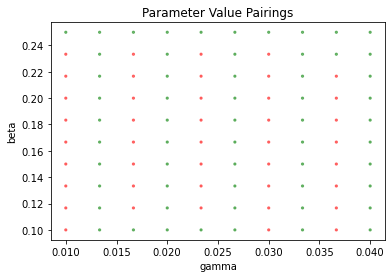

In [31]:
sir_model.plot_two_params("gamma", "beta", param_choices_true_false)
